In [1]:
import pandas as pd
import xarray as xr

import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import Polygon, mapping
#import rasterio as rio
#from rasterio.mask import mask
#from rasterio.plot import show
#from rasterio.plot import plotting_extent
import regionmask
import xesmf as xe

import sys
sys.path.append('../')
import utils
import plotting

import math


Bad key "text.kerning_factor" on line 4 in
/home/emfreese/anaconda3/envs/conda_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


Using raster = 4 to get the 2015 GWP population density

## Import Pollution Dataset

In [2]:
#### import our pollution datasets ####
poll_ds = xr.open_zarr("./data/nonuc_normal_GC.zarr/")



## Import Population Density and Land Area Datasets

In [3]:
#### import our dataset for population density ####
ds = xr.open_dataset("/net/fs11/d0/emfreese/population_data/gpw-v4-population-density-adjusted-to-2015-unwpp-country-totals-rev11_totpop_2pt5_min_nc/gpw_v4_population_density_adjusted_rev11_2pt5_min.nc")
pop_ds = ds.sel(raster = 4) #density in persons / sq km
pop_ds = pop_ds.rename({'latitude':'lat', 'longitude':'lon'})

pop_ds = pop_ds.assign_coords(coords = {'lat':pop_ds['lat']}) #fix the lat
pop_ds = pop_ds.fillna(0) 
pop_ds = pop_ds.rename({'UN WPP-Adjusted Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes':'pop_density'})

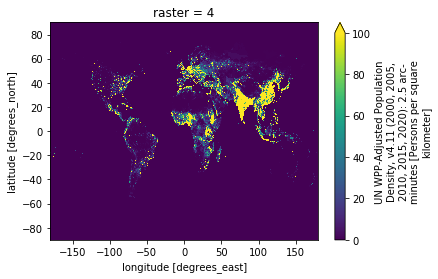

In [4]:
pop_ds['pop_density'].plot.imshow(vmax = 100)

In [5]:
#### import our dataset for land area ####
ds = xr.open_dataset("/net/fs11/d0/emfreese/population_data/gpw-v4-population-density-adjusted-to-2015-unwpp-country-totals-rev11_totpop_2pt5_min_nc/gpw_v4_population_density_adjusted_rev11_2pt5_min.nc")
land_ds = ds.sel(raster = 9) #density in persons / sq km
land_ds = land_ds.rename({'latitude':'lat', 'longitude':'lon'})

land_ds = land_ds.assign_coords(coords = {'lat':land_ds['lat']}) #fix the lat
land_ds = land_ds.fillna(0) 
land_ds = land_ds.rename({'UN WPP-Adjusted Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes':'land_area'})

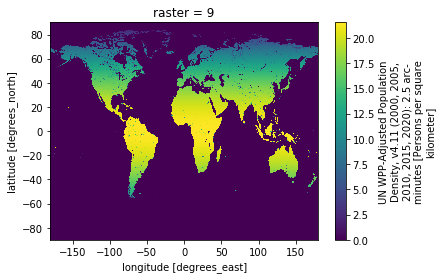

In [6]:
land_ds['land_area'].plot.imshow()

## Merge Land and Population Datasets, Calculate Total Area

In [7]:
#### merge our pop and land area datasets ####
land_pop_ds = xr.merge([pop_ds, land_ds], compat='override')

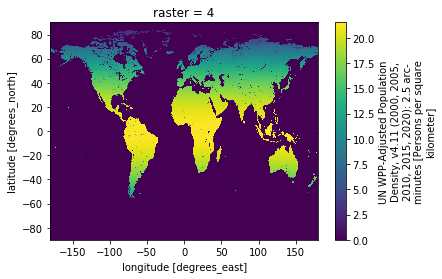

In [8]:
land_pop_ds['land_area'].plot.imshow()

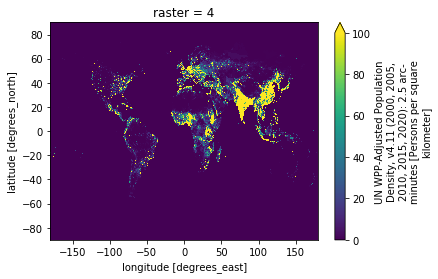

In [9]:
land_pop_ds['pop_density'].plot.imshow(vmax = 100)

In [10]:
#### create lat and lon bounds ####
lonb = land_pop_ds['lon'].values + (land_pop_ds['lon'][0]-land_pop_ds['lon'][1]).values/2
lonb = np.append(lonb, (lonb[-1] - (land_pop_ds['lon'][0]-land_pop_ds['lon'][1]).values))

latb = land_pop_ds['lat'].values + (land_pop_ds['lat'][0]-land_pop_ds['lat'][1]).values/2
latb = np.append(latb, (latb[-1] - (land_pop_ds['lat'][0]-land_pop_ds['lat'][1]).values))

land_pop_ds['lon_b'] = lonb
land_pop_ds['lat_b'] = latb

In [11]:
#### function to find area of a grid cell from lat/lon ####
def find_area(ds, R = 6378.1):
    """ ds is the dataset, i is the number of longitudes to assess, j is the number of latitudes, and R is the radius of the earth in km. 
    Must have the ds['lat'] in descending order (90...-90)
    Returns Area of Grid cell in km"""
    
    dy = (ds['lat_b']- ds['lat_b'].roll({'lat_b':-1}, roll_coords = False))[:-1]*2*np.pi*R/360 

    dx1 = (ds['lon_b'].roll({'lon_b':-1}, roll_coords = False) - 
           ds['lon_b'])[:-1]*2*np.pi*R*np.cos(np.deg2rad(ds['lat_b']))
    
    dx2 = (ds['lon_b'].roll({'lon_b':-1}, roll_coords = False) - 
           ds['lon_b'])[:-1]*2*np.pi*R*np.cos(np.deg2rad(ds['lat_b'].roll({'lat_b':-1}, roll_coords = False)[:-1]))
    
    A = .5*(dx1+dx2)*dy
    
    #### assign new lat and lon coords based on the center of the grid box instead of edges ####
    A = A.assign_coords(lon_b = ds.lon.values,
                    lat_b = ds.lat.values)
    A = A.rename({'lon_b':'lon','lat_b':'lat'})

    A = A.transpose()
    
    return(A)

In [12]:
#### find the area of our original grid cells ####
A = find_area(land_pop_ds)



In [13]:
#### merge to create a new ds with all of our original land and population data ####
orig_ds = xr.merge([land_pop_ds, A.to_dataset(name = 'orig_total_area')])

orig_ds['land_area_ratio'] = orig_ds['land_area']/orig_ds['orig_total_area']
orig_ds['orig_pop_count'] = orig_ds['pop_density']* orig_ds['land_area']


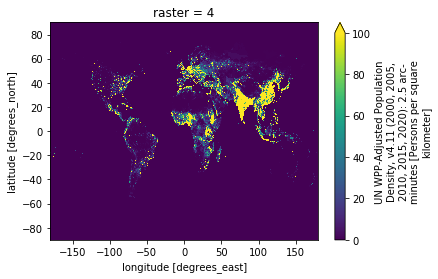

In [14]:
orig_ds['pop_density'].plot.imshow(vmax = 100)

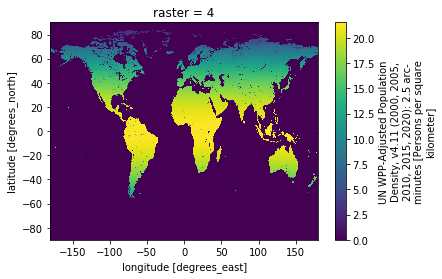

In [15]:
orig_ds['land_area'].plot.imshow()

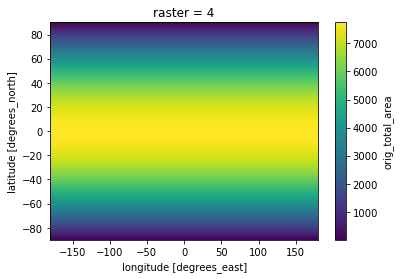

In [16]:
orig_ds['orig_total_area'].plot.imshow()

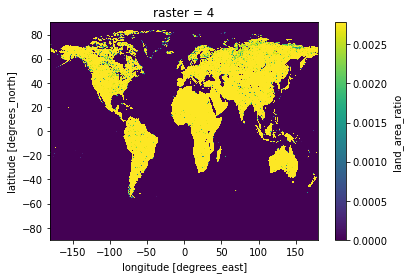

In [17]:
orig_ds['land_area_ratio'].plot.imshow()

## Regrid our dataset

In [18]:
def make_2d_grid(lon_b1, lon_b2, lon_step, lat_b1, lat_b2, lat_step):
    lon_bounds = np.arange(lon_b1, lon_b2+lon_step, lon_step)
    lon_centers = (lon_bounds[:-1] + lon_bounds[1:])/2
    
    lat_bounds = np.arange(lat_b1, lat_b2+lat_step, lat_step)[::-1]
    lat_centers = (lat_bounds[:-1] + lat_bounds[1:])/2
    
    ds = xr.Dataset({'lat': (['lat'], lat_centers),
                     'lon': (['lon'], lon_centers),
                     'lat_b': (['lat_b'], lat_bounds),
                     'lon_b': (['lon_b'], lon_bounds),
                    }
                   )
    return(ds)

In [19]:
#make a ds with grid for output and grid for input 
lat_dif = .5 
lon_dif = .625
ds_out = make_2d_grid(-180, 180, lon_dif, 90, -90, -lat_dif) #grid that we want to regrid to
ds_in = make_2d_grid(-180, 180, .041666667, -90, 90, .041666667) #same as the grid for orig_ds

In [20]:
#create regridder (reusing weights)
regridder = xe.Regridder(ds_in, ds_out, 'conservative', reuse_weights = True)
regridder  # print basic regridder information.

#regrid according to our ds_out grid
regrid_ds = regridder(orig_ds)

#update the latb and lonb so that they match the ds_out values
regrid_ds['lon_b'] = ds_out['lon_b']
regrid_ds['lat_b'] = ds_out['lat_b']

regrid_ds #look at our regridded dataset

/home/emfreese/anaconda3/envs/conda_env/lib/python3.7/site-packages/xesmf/backend.py:52: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn("Latitude is outside of [-90, 90]")


Reuse existing file: conservative_4320x8640_360x576.nc
using dimensions ('lat', 'lon') from data variable pop_density as the horizontal dimensions for this dataset.


/home/emfreese/anaconda3/envs/conda_env/lib/python3.7/site-packages/xesmf/smm.py:70: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not C_CONTIGUOUS. "


<xarray.Dataset>
Dimensions:          (lat: 360, lat_b: 361, lon: 576, lon_b: 577)
Coordinates:
    raster           int32 4
  * lon_b            (lon_b) float64 -180.0 -179.4 -178.8 ... 178.8 179.4 180.0
  * lat_b            (lat_b) float64 -90.0 -89.5 -89.0 -88.5 ... 89.0 89.5 90.0
  * lon              (lon) float64 -179.7 -179.1 -178.4 ... 178.4 179.1 179.7
  * lat              (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
Data variables:
    pop_density      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    land_area        (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    orig_total_area  (lat, lon) float64 44.98 44.98 44.98 ... 44.98 44.98 44.98
    land_area_ratio  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    orig_pop_count   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  conservative

In [21]:
#### find the area of our original grid cells ####
A = find_area(regrid_ds)

Area_ds = A.to_dataset(name = 'regrid_total_area')
Area_ds = Area_ds*-1

regrid_area_ds = xr.merge([regrid_ds, Area_ds])
regrid_area_ds = regrid_area_ds.drop(['orig_pop_count', 'land_area', 'orig_total_area'])

In [22]:
#### create new variables in regridded ds ####

regrid_area_ds['regrid_land_area'] = regrid_area_ds['land_area_ratio'] * regrid_area_ds['regrid_total_area'] 

regrid_area_ds['regrid_pop_count'] = regrid_area_ds['regrid_land_area'] * regrid_area_ds['pop_density']

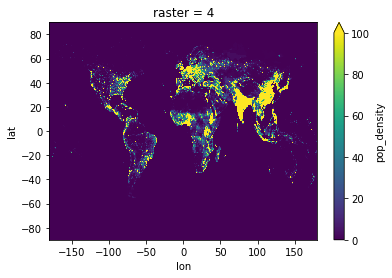

In [23]:
regrid_area_ds['pop_density'].plot.imshow(vmax = 100)

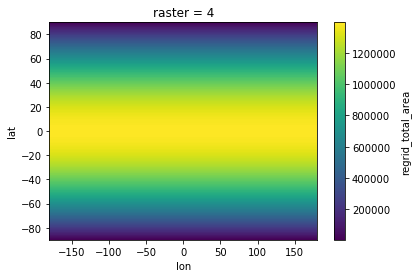

In [24]:
regrid_area_ds['regrid_total_area'].plot.imshow()

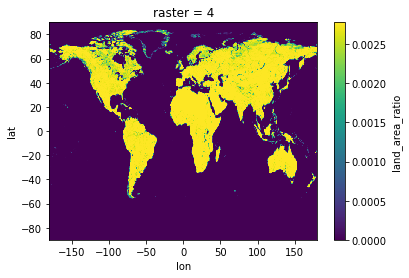

In [25]:
regrid_area_ds['land_area_ratio'].plot.imshow()

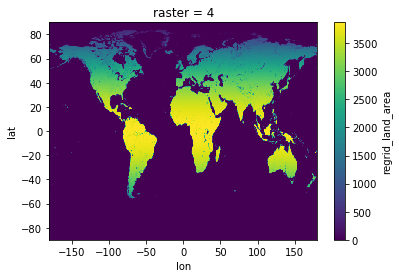

In [26]:
regrid_area_ds['regrid_land_area'].plot.imshow()

In [27]:
#### check that we still have ~7 billion population ####
print(regrid_area_ds['regrid_pop_count'].sum(), orig_ds['orig_pop_count'].sum())

<xarray.DataArray 'regrid_pop_count' ()>
array(7.008563e+09)
Coordinates:
    raster   int32 4 <xarray.DataArray 'orig_pop_count' ()>
array(7.349324e+09, dtype=float32)
Coordinates:
    raster   int32 4


## Mask our data to just the United States

In [28]:
#### create a mask ####
states = regionmask.defined_regions.natural_earth.us_states_50
lon = np.arange(230, 300, .25)
lat = np.arange(50, 24, -.125)
mask = states.mask(regrid_area_ds, lon_name = 'lon', lat_name = 'lat')
contiguous_mask = ~np.isnan(mask) & (mask != 0.) & (mask != 11) 

#### mask our population dataset ####
US_land_pop_ds = regrid_area_ds.where(contiguous_mask)

#### mask our pollution dataset ####
US_poll_ds = poll_ds.where(contiguous_mask)

total US population 294193664.8137231


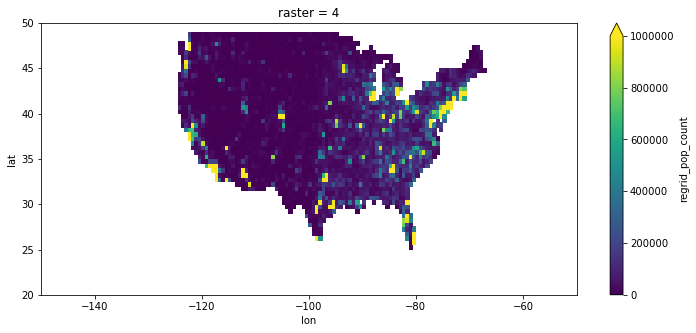

In [29]:
US_land_pop_ds['regrid_pop_count'].plot(figsize = (12,5), vmax = 1000000)
plt.xlim(-150,-50)
plt.ylim(20,50)
print('total US population', US_land_pop_ds['regrid_pop_count'].sum().values)

## CRF

In [30]:
#### import our observational data #####

#mortality data from IHME GBD 2017
obs_mortality = pd.read_csv('../../health_data/global_burden_disease_2017_data/IHME-GBD_2017_DATA-2c4a32b7-1.csv')
obs_mortality = obs_mortality.drop([1,2,3,4,5])

#concentration data from van Donkelaar 2019 http://fizz.phys.dal.ca/~atmos/martin/?page_id=140 (replace with Di et al)
obs_concentration = xr.open_dataset('../../health_data/concentration_data/GWRwSPEC.HEI.ELEVandURB_PM25_NA_201601_201612-RH35.nc')

In [31]:
obs_concentration = obs_concentration.rename({'PM25':'chi_obs_PM25'})

In [32]:
I_obs = np.full((len(obs_concentration['LAT']), len(obs_concentration['LON'])), obs_mortality['val'])

In [33]:
I_obs_ds = xr.DataArray(I_obs, 
             dims=('LAT', 'LON'),
             coords = {'LAT':obs_concentration['LAT'].values, 'LON':obs_concentration['LON'].values},
            name = 'I_obs')

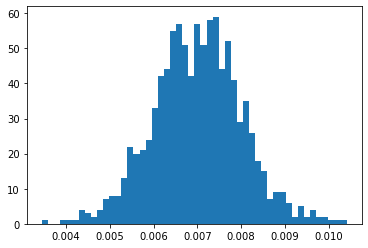

In [34]:
delta_chi = 10 #ug/m3 from Di et al 2017
RR = 1.073 
beta = np.log(RR)/delta_chi
CI_min = 1.071
sd = (RR-CI_min)/2

beta_normal_dist = np.random.normal(beta, sd, 1000)
plt.hist(beta_normal_dist, 50);

In [35]:
beta

0.007045846364856137

beta_ds = xr.DataArray(np.full((len(obs_concentration['LAT']), len(obs_concentration['LON']), 1000), beta),
                       dims = ('LAT', 'LON', 'dist'),
                       coords = {'LAT':obs_concentration['LAT'].values, 'LON':obs_concentration['LON'].values, 'dist': np.arange(0,1)},
                       name = 'beta')

In [36]:
obs_concentration

<xarray.Dataset>
Dimensions:       (LAT: 4550, LON: 9300)
Coordinates:
  * LON           (LON) float64 -138.0 -138.0 -138.0 ... -45.03 -45.01 -45.01
  * LAT           (LAT) float64 68.0 67.99 67.97 67.96 ... 22.52 22.51 22.5
Data variables:
    chi_obs_PM25  (LAT, LON) float32 ...

In [37]:
obs_ds = xr.merge((I_obs_ds, obs_concentration))

In [38]:
obs_ds

<xarray.Dataset>
Dimensions:       (LAT: 4550, LON: 9300)
Coordinates:
  * LAT           (LAT) float64 68.0 67.99 67.97 67.96 ... 22.52 22.51 22.5
  * LON           (LON) float64 -138.0 -138.0 -138.0 ... -45.03 -45.01 -45.01
Data variables:
    I_obs         (LAT, LON) float64 2.794e+06 2.794e+06 ... 2.794e+06 2.794e+06
    chi_obs_PM25  (LAT, LON) float32 ...

In [38]:
###### bootstrap pairs function ######       
def draw_bs(x, size=1):
    #Perform pairs bootstrap for linear regression

    # Set up array of indices to sample from: inds
    inds = np.arange(0,len(x))

    # Generate replicates
    bs_inds = np.random.choice(inds, size=size)
    bs_val= x[bs_inds]
        
    return bs_val

In [39]:
obs_ds

<xarray.Dataset>
Dimensions:       (LAT: 4550, LON: 9300)
Coordinates:
  * LAT           (LAT) float64 68.0 67.99 67.97 67.96 ... 22.52 22.51 22.5
  * LON           (LON) float64 -138.0 -138.0 -138.0 ... -45.03 -45.01 -45.01
Data variables:
    I_obs         (LAT, LON) float64 2.794e+06 2.794e+06 ... 2.794e+06 2.794e+06
    chi_obs_PM25  (LAT, LON) float32 ...

sample_size = 1
obs_ds['beta_bs'] = xr.DataArray(
                        data = np.zeros((obs_ds.dims['LAT'], obs_ds.dims['LON'], sample_size)), 
                        coords = (obs_ds.coords['LAT'], obs_ds.coords['LON'], xr.DataArray(np.arange(0,sample_size))),
                        dims = ('LAT','LON','sample')
                    )


for lat in obs_ds['LAT']:
    for lon in obs_ds['LON']:
        tmp_ds = draw_bs(obs_ds['beta'].sel(LAT = lat, LON = lon).values, size = sample_size)
        obs_ds['beta_bs'].loc[dict(LAT = lat, LON = lon)] = tmp_ds

obs_ds.to_netcdf('./data/obs_ds_CRF_new', 'w')

xr.open_dataset('./data/obs_ds_CRF')

1. assign population ($p_{aff}$), concentrations ($\chi_{POL}, \chi_{OBS}, \chi_{BASE}$) and observed mortality ($I_{OBS}$)
2. find beta samples (lat, lon, sample #)
3. find beta distribution (lat, lon, dist #)
3. calculate $\Delta I$/$I_{OBS}$ as $\exp (\beta [\chi_{POL}-\chi_{OBS}])- \exp(\beta [\chi_{BASE}-\chi_{OBS}])$ along (lat, lon, dist #)
4. calculate $\Delta I$ as $ p_{aff}*I_{OBS}*\Delta I/I_{OBS} $ along (lat, lon, dist #)
5. calculate the mean and the standard deviation along (lat, lon)
6. return the mean and standard deviation along (lat, lon)

$\beta* I_{obs} * \delta \chi * p_{aff}$

In [45]:
#merge our population dataset with our observation dataset
obs_pop_ds = xr.merge((obs_ds.rename({'LAT':'lat','LON':'lon'}), US_land_pop_ds))


<xarray.Dataset>
Dimensions:  (lat: 60, lat_b: 61, lon: 160, lon_b: 161)
Coordinates:
  * lat      (lat) float64 20.25 20.75 21.25 21.75 ... 48.25 48.75 49.25 49.75
  * lon      (lon) float64 -149.7 -149.1 -148.4 -147.8 ... -51.56 -50.94 -50.31
  * lat_b    (lat_b) float64 20.0 20.5 21.0 21.5 22.0 ... 48.5 49.0 49.5 50.0
  * lon_b    (lon_b) float64 -150.0 -149.4 -148.8 -148.1 ... -51.25 -50.62 -50.0
Data variables:
    *empty*

In [87]:
#make a ds with grid for output and grid for input 
lat_dif = .5 
lon_dif = .625
ds_out = make_2d_grid(-180, 180, lon_dif, 90, -90, -lat_dif) #grid that we want to regrid to
ds_in = make_2d_grid(-180, 180, .01, -90, 90, .01) #same as the grid for orig_ds

#create regridder (reusing weights)
regridder = xe.Regridder(ds_in.sel(lon = slice(-150,-50), lat = slice(50,20), lat_b = slice(50.01,20),lon_b = slice(-150.01,-50)), 
                        ds_out.sel(lon = slice(-150,-50), lat = slice(20,50), lat_b = slice(20,50.01),lon_b = slice(-150.01,-50)),
                         'conservative')
regridder  # print basic regridder information.

#regrid according to our ds_out grid
regrid_ds = regridder(obs_ds.sel(lon = slice(-150,-50), lat = slice(20,50)))

#update the latb and lonb so that they match the ds_out values
#regrid_ds['lon_b'] = ds_out['lon_b']
#regrid_ds['lat_b'] = ds_out['lat_b']

regrid_ds #look at our regridded dataset

Create weight file: conservative_3000x10000_60x160.nc


ValueError: dimensions or multi-index levels ['lon', 'lat'] do not exist

In [64]:
obs_ds.rename({'LAT':'lat','LON':'lon'})['lon'][0]- obs_ds.rename({'LAT':'lat','LON':'lon'})['lon'][1]

<xarray.DataArray 'lon' ()>
array(-0.009995)

In [58]:
US_land_pop_ds

<xarray.Dataset>
Dimensions:            (lat: 360, lat_b: 361, lon: 576, lon_b: 577)
Coordinates:
    raster             int32 4
  * lon_b              (lon_b) float64 -180.0 -179.4 -178.8 ... 179.4 180.0
  * lat_b              (lat_b) float64 -90.0 -89.5 -89.0 ... 89.0 89.5 90.0
  * lon                (lon) float64 -179.7 -179.1 -178.4 ... 178.4 179.1 179.7
  * lat                (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
Data variables:
    pop_density        (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    land_area_ratio    (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    regrid_total_area  (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    regrid_land_area   (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    regrid_pop_count   (lat, lon) float64 nan nan nan nan ... nan nan nan nan

In [46]:
obs_pop_ds

<xarray.Dataset>
Dimensions:            (lat: 4910, lat_b: 361, lon: 9876, lon_b: 577)
Coordinates:
  * lat                (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * lon                (lon) float64 -179.7 -179.1 -178.4 ... 178.4 179.1 179.7
    raster             int32 4
  * lon_b              (lon_b) float64 -180.0 -179.4 -178.8 ... 179.4 180.0
  * lat_b              (lat_b) float64 -90.0 -89.5 -89.0 ... 89.0 89.5 90.0
Data variables:
    I_obs              (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    chi_obs_PM25       (lat, lon) float32 nan nan nan nan ... nan nan nan nan
    pop_density        (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    land_area_ratio    (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    regrid_total_area  (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    regrid_land_area   (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    regrid_pop_count   (lat, lon) float64 nan nan nan nan ... nan nan nan nan

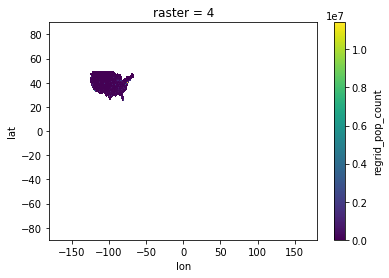

In [47]:
US_land_pop_ds['regrid_pop_count'].plot()

In [55]:
#merge our model dataset with our observ/pop dataset
ds = xr.merge((obs_pop_ds, poll_ds))


In [57]:
obs_pop_ds

<xarray.Dataset>
Dimensions:            (lat: 4910, lat_b: 361, lon: 9876, lon_b: 577)
Coordinates:
  * lat                (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * lon                (lon) float64 -179.7 -179.1 -178.4 ... 178.4 179.1 179.7
    raster             int32 4
  * lon_b              (lon_b) float64 -180.0 -179.4 -178.8 ... 179.4 180.0
  * lat_b              (lat_b) float64 -90.0 -89.5 -89.0 ... 89.0 89.5 90.0
Data variables:
    I_obs              (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    chi_obs_PM25       (lat, lon) float32 nan nan nan nan ... nan nan nan nan
    pop_density        (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    land_area_ratio    (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    regrid_total_area  (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    regrid_land_area   (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    regrid_pop_count   (lat, lon) float64 nan nan nan nan ... nan nan nan nan

In [49]:
#calculate our $\Delta I$/$I_{OBS}$
ds['deltaI_Iobs'] = np.exp(beta*(ds['PM25'].sel(model_name = 'nonuc_model').mean(dim = 'time') - 
                                       ds['chi_obs_PM25'])) - np.exp(beta*(ds['PM25'].sel(model_name = 'normal_model').mean(dim = 'time') - 
                                                                                 ds['chi_obs_PM25']))

In [50]:
ds['deltaI_Iobs'].sel(lon = slice(-150,-50), lat = slice(20,50))

<xarray.DataArray 'deltaI_Iobs' (lat: 2871, lon: 9035)>
dask.array<getitem, shape=(2871, 9035), dtype=float32, chunksize=(2871, 9035)>
Coordinates:
  * lat      (lat) float64 20.0 20.25 20.5 20.75 21.0 ... 49.97 49.99 49.99 50.0
  * lon      (lon) float64 -149.7 -149.1 -148.4 -147.8 ... -50.01 -50.01 -50.0
    raster   int32 4
    lev      float64 ...

In [51]:
#calculate our delta I
ds['deltaI'] = ds['deltaI_Iobs'].sel(lon = slice(-150,-50), lat = slice(20,50)) * ds['I_obs'].sel(lon = slice(-150,-50), lat = slice(20,50)) * ds['pop_density'].sel(lon = slice(-150,-50), lat = slice(20,50))

In [54]:
ds

<xarray.Dataset>
Dimensions:                                    (ilev: 48, lat: 5031, lat_b: 361, lon: 9963, lon_b: 577, model_name: 2, time: 366)
Coordinates:
  * lat                                        (lat) float64 -89.75 ... 89.75
  * lon                                        (lon) float64 -179.7 ... 179.7
    raster                                     int32 4
  * lon_b                                      (lon_b) float64 -180.0 ... 180.0
  * lat_b                                      (lat_b) float64 -90.0 ... 90.0
  * ilev                                       (ilev) float64 1.0 ... 1e-05
    lev                                        float64 ...
  * model_name                                 (model_name) object 'normal_model' 'nonuc_model'
  * time                                       (time) datetime64[ns] 2016-01-01T12:00:00 ... 2016-12-31T12:00:00
Data variables:
    I_obs                                      (lat, lon) float64 nan ... nan
    chi_obs_PM25                               (lat, lon) float32 nan ... nan
    pop_density                                (lat, lon) float64 nan ... nan
    land_area_ratio                            (lat, lon) float64 nan ... nan
    regrid_total_area                          (lat, lon) float64 nan ... nan
    regrid_land_area                           (lat, lon) float64 nan ... nan
    regrid_pop_count                           (lat, lon) float64 nan ... nan
    BCPI                                       (model_name, time, lat, lon) float32 dask.array<chunksize=(1, 1, 5031, 9963), meta=np.ndarray>
    BCPO                                       (model_name, time, lat, lon) float32 dask.array<chunksize=(1, 1, 5031, 9963), meta=np.ndarray>
    CH2O                                       (model_name, time, lat, lon) float32 dask.array<chunksize=(1, 1, 5031, 9963), meta=np.ndarray>
    CH2O_NO2                                   (model_name, time, lat, lon) float32 dask.array<chunksize=(1, 1, 5031, 9963), meta=np.ndarray>
    DST1                                       (model_name, time, lat, lon) float32 dask.array<chunksize=(1, 1, 5031, 9963), meta=np.ndarray>
    DST2                                       (model_name, time, lat, lon) float32 dask.array<chunksize=(1, 1, 5031, 9963), meta=np.ndarray>
    H2O2                                       (model_name, time, lat, lon) float32 dask.array<chunksize=(1, 1, 5031, 9963), meta=np.ndarray>
    H2O2_HNO3                                  (model_name, time, lat, lon) float32 dask.array<chunksize=(1, 1, 5031, 9963), meta=np.ndarray>
    HNO3                                       (model_name, time, lat, lon) float32 dask.array<chunksize=(1, 1, 5031, 9963), meta=np.ndarray>
    NH3                                        (model_name, time, lat, lon) float32 dask.array<chunksize=(1, 1, 5031, 9963), meta=np.ndarray>
    NH4                                        (model_name, time, lat, lon) float32 dask.array<chunksize=(1, 1, 5031, 9963), meta=np.ndarray>
    NIT                                        (model_name, time, lat, lon) float32 dask.array<chunksize=(1, 1, 5031, 9963), meta=np.ndarray>
    NO                                         (model_name, time, lat, lon) float32 dask.array<chunksize=(1, 1, 5031, 9963), meta=np.ndarray>
    NO2                                        (model_name, time, lat, lon) float32 dask.array<chunksize=(1, 1, 5031, 9963), meta=np.ndarray>
    NO3                                        (model_name, time, lat, lon) float32 dask.array<chunksize=(1, 1, 5031, 9963), meta=np.ndarray>
    NOx                                        (model_name, time, lat, lon) float32 dask.array<chunksize=(1, 1, 5031, 9963), meta=np.ndarray>
    O3                                         (model_name, time, lat, lon) float32 dask.array<chunksize=(1, 1, 5031, 9963), meta=np.ndarray>
    OCPI                                       (model_name, time, lat, lon) float32 dask.array<chunksize=(1, 1, 5031, 9963), meta=np.ndarray>
    OCPO 

In [52]:
ds['deltaI'].plot()

KeyboardInterrupt: 

In [60]:
ds['deltaI'].values

/home/emfreese/anaconda3/envs/conda_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/emfreese/anaconda3/envs/conda_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [57]:
#take the mean along lat and lon
ds['deltaI'].mean(dim = ['lat','lon'])
ds['deltaI'].std(dim = ['lat','lon'])

<xarray.DataArray 'deltaI' ()>
dask.array<sqrt, shape=(), dtype=float64, chunksize=()>
Coordinates:
    raster   int32 4
    lev      float64 ...

In [ ]:
def interpolate_band(da, int_dates):
    # Apply ufunc-- inputs xr.DataArray and dates for interpolation
    # returns data array with interpolated values for int_dates
    result = xr.apply_ufunc(ufunc_cubic_spline, da,
                            input_core_dims=[['time']],
                            output_core_dims=[['ntime']],
                            kwargs={'axis': -1,
                                    'orig_times': da.time.values,
                                    'new_times': int_dates},
                            dask='parallelized',
                            output_dtypes=[np.float32],
                            output_sizes={'ntime':int_dates.shape[0]})
    result['ntime'] = ('ntime', int_time)
    return result
def ufunc_cubic_spline(a, axis, orig_times, new_times):
    # Reshape array to 2d (pixels, dates)
    data = a.reshape(axis, a.shape[axis])
    # Fit cubic spline and interpolate dates
    results = np.apply_along_axis(_cubic_spline, 1, data,
                                  orig_times=orig_times,
                                  new_times=new_times)
    # Reshape to original pixels (y,x) and number of interpolated dates
    return results.reshape((a.shape[0],a.shape[1],new_times.shape[0]))
#for the interpolation I'm using numpy's CubicSpline

def _cubic_spline(y, orig_times, new_times):
    # Filter NaNs
    nans = np.isnan(y)#.values)[:,0]
    # Try to fit cubic spline with filtered y values
    try:
        spl = interpolate.CubicSpline(orig_times.astype('d')[~nans],
                                      y[~nans])
        
        interpolated = spl(new_times.astype('d'))
    
    except ValueError:
        ## When spline cannot be fitted(not enought data), return NaN
        ## TODO raise warning
        interpolated = np.empty(new_times.shape[0])
        interpolated[:] = np.nan
        
    return interpolated

In [41]:
###### bootstrap pairs function ######       
def draw_bs(x, size=1):
    #Perform pairs bootstrap for linear regression

    # Set up array of indices to sample from: inds
    inds = np.arange(0,len(x))

    # Generate replicates
    bs_inds = np.random.choice(inds, size=size)
    bs_val= x[bs_inds]
        
    return bs_val

In [112]:
def apply_bs(da, x, size):
    da_bs = xr.apply_ufunc(draw_bs , da, 
                  input_core_dims = [['sample']],
                  output_core_dims = [['sample']],
                  exclude_dims=set(("sample",)),
                           vectorize=True
                  )
    return(da_bs)

I_obs_ds.expand_dims({'sample':1000})

In [113]:
da_bs = apply_bs(I_obs_ds.expand_dims({'sample':1000}), beta_normal_dist, 10)

ValueError: inconsistent size for core dimension 'dim0': 1 vs 1000

In [101]:
I_obs_ds

<xarray.DataArray 'I_obs' (LAT: 4550, LON: 9300)>
array([[2793730.29875274, 2793730.29875274, 2793730.29875274, ...,
        2793730.29875274, 2793730.29875274, 2793730.29875274],
       [2793730.29875274, 2793730.29875274, 2793730.29875274, ...,
        2793730.29875274, 2793730.29875274, 2793730.29875274],
       [2793730.29875274, 2793730.29875274, 2793730.29875274, ...,
        2793730.29875274, 2793730.29875274, 2793730.29875274],
       ...,
       [2793730.29875274, 2793730.29875274, 2793730.29875274, ...,
        2793730.29875274, 2793730.29875274, 2793730.29875274],
       [2793730.29875274, 2793730.29875274, 2793730.29875274, ...,
        2793730.29875274, 2793730.29875274, 2793730.29875274],
       [2793730.29875274, 2793730.29875274, 2793730.29875274, ...,
        2793730.29875274, 2793730.29875274, 2793730.29875274]])
Coordinates:
  * LAT      (LAT) float64 68.0 67.99 67.97 67.96 ... 22.53 22.52 22.51 22.5
  * LON      (LON) float64 -138.0 -138.0 -138.0 -138.0 ... -45.03 -45.01 -45.01

In [38]:
def mean(obj, dim1, dim2):
    # note: apply always moves core dimensions to the end
    return xr.apply_ufunc(np.mean, obj,
                       input_core_dims=[[dim1, dim2]],
                       #kwargs={'axis': -1}
                         )

In [39]:
mean(I_obs_ds, 'LON','LAT')

<xarray.DataArray 'I_obs' ()>
array(2793730.2987524)